# GradCAM

In [1]:
import wheel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

import os
import os.path
from os import path
import cv2
import json
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

from google.colab import drive
from os import path
drive.mount('/content/drive')

data_root = './drive/MyDrive/NAS/CSED538/DL20'
model_root = './drive/MyDrive/NAS/CSED538/simpleCNN.pth'
print(path.exists(data_root))
print(path.exists(model_root))

Mounted at /content/drive
True
True


In [2]:
class SimpleCNN(nn.Module):
  def __init__(self, num_classes=20):
    super(SimpleCNN, self).__init__()

    self.relu = nn.ReLU(inplace=True)
    
    # Convolution Feature Extraction Part
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.bn1   = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn2   = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc    = nn.Linear(128*16*16, 20)
  def forward(self, x):
    # Convolution Feature Extraction Part
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool2(x)

    # Fully Connected Classifier Part
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

In [3]:
model = SimpleCNN(num_classes=20)
model.load_state_dict(torch.load(model_root))

# Random input
x = torch.randn((1, 3, 64, 64))
out = model(x)
print("Output tensor shape is :", out.shape)

Output tensor shape is : torch.Size([1, 20])


In [4]:
class LoadDataset(Dataset):
    def __init__(self, data_path, transform, mode='train'):
        super(LoadDataset, self).__init__()
        self.data_path = data_path
        self.mode = mode
        self.transform = transform
        
        if mode == "test":
            self.test_load()
        else : 
            self.load_dataset()

    def test_load(self):
        root = os.path.join(self.data_path, self.mode)
        print("root : ", root)
        self.data = glob(root+"/*.png")
        
    def load_dataset(self):
        root = os.path.join(self.data_path, self.mode)
        print("root : ", root)
        self.data = ImageFolder(root=root)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == "test":
            img = Image.open(self.data[index]).convert('RGB')
            img = self.transform(img)
            return img
        else:
            img, label = self.data[index]
            img, label = self.transform(img), int(label)
            return img, label

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 32
test_dataset = LoadDataset(data_root, transform, "test")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

root :  ./drive/MyDrive/NAS/CSED538/DL20/test


In [39]:
save_feat=[]
def hook_feat(module, input, output):
  save_feat.append(output)
  return output

save_grad=[]
def hook_grad(grad):
  """
  get a gradient from intermediate layers (dy / dA).
  See the .register-hook function for usage.
  :return grad: (Variable) gradient dy / dA
  """ 
  save_grad.append(grad)
  return grad

def vis_gradcam(model, img):
  """
  Imshow the grad_CAM.
  :param model: model
  :param img: a sample image
  output : plt.imshow(grad_CAM)
  """
  model.eval()

  # Reister hook for storing layer activation of the target layer (bn5_2 in backbone)
  model.bn2.register_forward_hook(hook_feat)
  
  # Forward pass to hook features
  img = img.unsqueeze(0)
  s = model(img)[0]

  # Register hook for storing gradients
  save_feat[0].register_hook(hook_grad)
  
  # Backward score
  y = torch.argmax(s).item()
  s_y = s[y]
  s_y.backward()

  # Compute activation at global-average-pooling layer
  gap_layer  = torch.nn.AdaptiveAvgPool2d(1)
  alpha = gap_layer(save_grad[0][0])
  A = save_feat[0]
  A = A.squeeze()

  # Compute grad_CAM
  relu_layer = torch.nn.ReLU()

  weighted_sum = torch.sum(alpha*A, dim=0)
  grad_CAM = relu_layer(weighted_sum)

  grad_CAM = grad_CAM.unsqueeze(0)
  grad_CAM = grad_CAM.unsqueeze(0)

  # Upscale grad_CAM
  upscale_layer = torch.nn.Upsample(scale_factor=img.shape[-1]/grad_CAM.shape[-1], mode='bilinear')
  grad_CAM = upscale_layer(grad_CAM)
  grad_CAM = grad_CAM/torch.max(grad_CAM)

  # Plotting
  img_np = img.permute(0, 2, 3, 1).numpy()
  if len(img_np.shape) > 3:
    img_np = img_np[0]
  
  grad_CAM = grad_CAM.squeeze().detach().numpy()

  plt.imshow(img_np)
  plt.imshow(grad_CAM, cmap='jet', alpha = 0.6)
  plt.show

  return grad_CAM

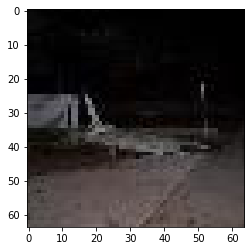

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


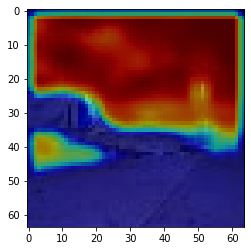

In [40]:
for test_images in test_loader:  
    img = test_images[0] 
    break


plt.imshow( img.permute(1, 2, 0) )
plt.show()
res = vis_gradcam(model.float(), img)